In this notebook we use the final model built in the [previous notebook](./AmazonForest-model-train-V2.ipynb) to visualize the activation features of the CNN layers.<BR><BR>
To view the activation features we build a new model which is a subset of the original model comprising only of the CNN layers.<BR>
The model has the same input as the original model, but the output is from the CNN layers.

#### Lets first import the required libraries

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from utils import data_utils, model_utils, plot_utils
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

#### Configure the number of CPU threads to be used by independent non-blocking operations:

In [11]:
num_threads = 8
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

In [12]:
df_target = pd.read_csv('data/train_labels.csv')
df_target.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [4]:
categories = list(df_target.select_dtypes(include='int64').columns)

#### Load the data saved in the npz files during the pre-processing step
* Load the individual npz files,
* Retreive the data from these,
* Stack the data to create the numpy arrays corresponding to all the images and the labels.

In [5]:
%%time
file_path = 'data/amazon_forest_part*npz'
X, Y = data_utils.load_data(file_path)

CPU times: user 13.1 s, sys: 883 ms, total: 13.9 s
Wall time: 13.9 s


#### Use load_model method from the keras API to load the final version of the model built in the [notebook]()

In [67]:
best_model = 'amzn_forest_imgaug.best.hdf5'
model = load_model(best_model, custom_objects={'fbeta_score': model_utils.fbeta_score })

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

#### Extract the output from the CNN layers of our original model:

In [69]:
layer_outputs = []
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv2d' in layer.name:
        layer_outputs.append(model.layers[i].output)

#### Create a new model with input same as the inputs of the original, and outputs from the CNN layers of the original model:

In [70]:
activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

#### To visualize the activation features, we will select a sample image from the image dataset X and process it through the new model

* Lets first plot the sample image

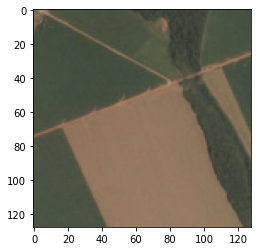

In [71]:
plt.imshow(np.squeeze(X[32]))

* Expand the dimensions of the image to create a batch of size 1 as an input to the model

In [72]:
img_x = np.expand_dims(X[32], axis=0)

In [73]:
img_x.shape

(1, 128, 128, 3)

* Process the image through the new model

In [74]:
cnn_activations = activation_model.predict(img_x)

* The output is the list of activation maps built by the CNN layers

#### Lets print the dimensions of the activation maps generated by each layer

In [75]:
for i, features in enumerate(cnn_activations):
    layer_name  = layer_outputs[i].name
    layer_shape = features.shape
    print('Dimensions of activation maps output by layer {} : {}'.format(layer_name, str(layer_shape)))

Dimensions of activation maps output by layer conv2d/Relu:0 : (1, 128, 128, 32)
Dimensions of activation maps output by layer conv2d_1/Relu:0 : (1, 128, 128, 32)
Dimensions of activation maps output by layer conv2d_2/Relu:0 : (1, 64, 64, 64)
Dimensions of activation maps output by layer conv2d_3/Relu:0 : (1, 64, 64, 64)
Dimensions of activation maps output by layer conv2d_4/Relu:0 : (1, 32, 32, 128)
Dimensions of activation maps output by layer conv2d_5/Relu:0 : (1, 32, 32, 128)


* We see that the first 2 CNN layers generate 32 activation maps of size 128 x 128
* The next 2 CNN layers generate 64 activation maps of size 64 x 64
* The last 2 CNN layers generate 128 activation maps of size 32 x 32<BR>

#### Lets define a function to visualize the activation maps
* For each output layer, the function plots a certain number of features detected by the layer
* The number of features to be plotted is set to 32

In [76]:
def plot_features(features, layer, num):
    '''
    INPUT:
    features (numpy.array) : numpy array representing the features built by the layers
    layer (str) : string representing the name of the CNN layer
    num (int) : total number of activation maps to be viewed for the layer
    
    OUTPUT:
    
    Description:
    The function uses matplotlib library to visualize the activation maps generated
    by the CNN layer
    '''
    fig = plt.figure(figsize=(12,8))
    title = 'Activation Features for Layer: ' + layer
    plt.title(title, fontsize=15, ha='center')
    plt.axis('off')
    for i in range(num):
        ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(features[0, :, :, i], cmap='jet')

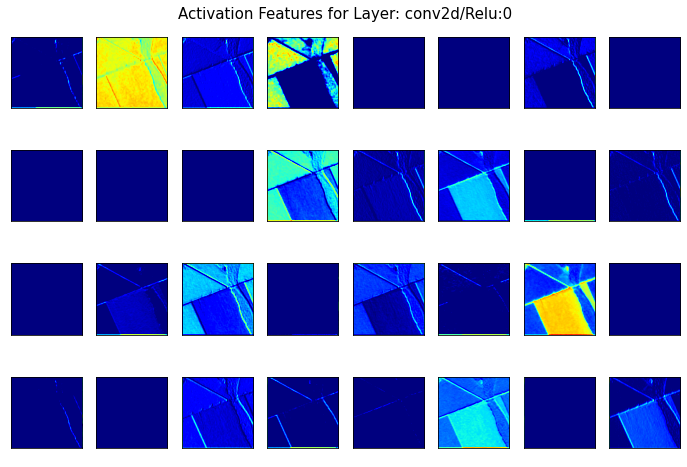

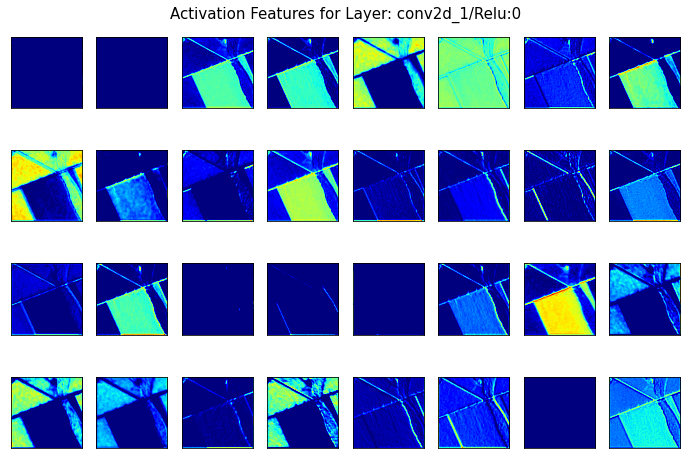

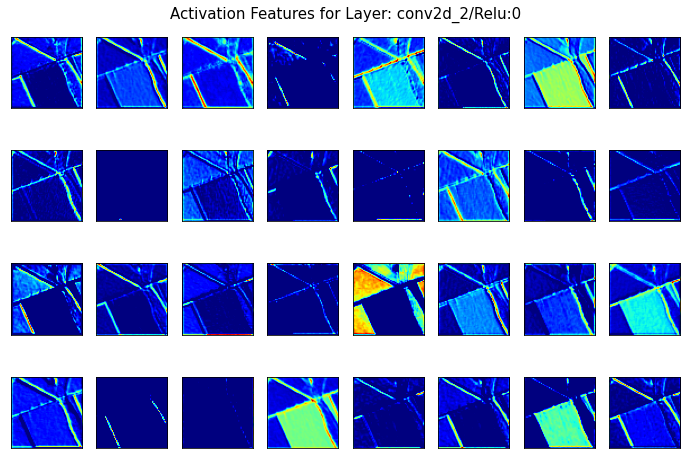

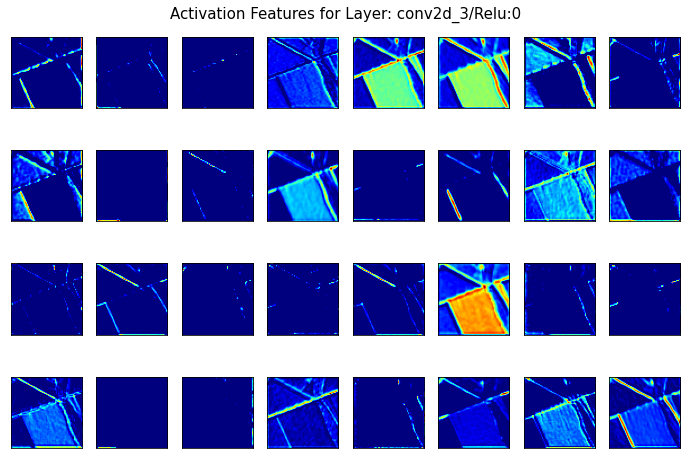

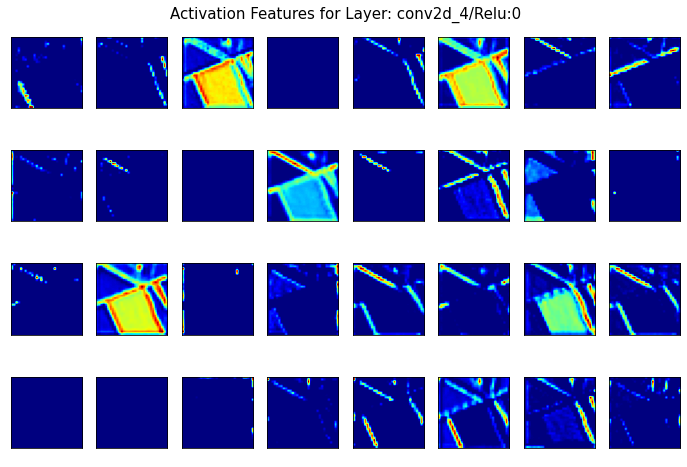

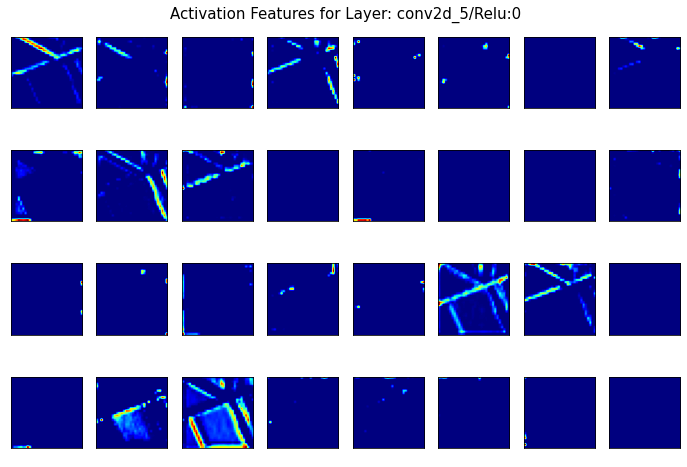

In [77]:
num = 32
for i, features in enumerate(cnn_activations):
    layer = layer_outputs[i].name
    plot_features(features, layer, num)

* We see that the activation maps captured by the first two CNN layers, detect a lot of fine details about the image.
* We can see the edges and shapes captured distinctly in these maps.
* As we go deeper into the layers, the activations tend to be more abstract, and less visually interpretable.
* The model tends to abstract features into more general concepts that can be used for classification.